# Looking for insects in UKMO WSR data using 

**Filtering notes:** currently using an additional "NCP>0.8" filter to remove some ground clutter.

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy
import xarray
import pandas as pd
import matplotlib.lines as mlines

import pyart
import netCDF4
import h5py as h5
from glob import glob
import os
import numpy as np
import cartopy.crs as ccrs
import warnings 
import time 
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import rasterio
import matplotlib
import wradlib
warnings.filterwarnings("ignore", category=DeprecationWarning)

from copy import deepcopy

from Aggregated_h5_loading import read_nimrod_aggregated_odim_h5
from wradlib import trafo


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Importing metadata

In [2]:
chenies_metadata = pd.read_csv('chenies_07092020_metadata.csv')

In [3]:
chenies_metadata

night  mean_cover  mean_precip  Xestia xanthographa count
0      7   87.934444     0.206667                       17.0
1      8   15.766667     0.116667                       22.0
2      9   12.026667     0.000000                       26.0
3     10   59.027778     0.000000                       19.0
4     11   39.052222     0.026667                       19.0
5     12   78.154444     0.136667                       19.0
6     13    6.313333     0.055556                       22.0
7     14    4.412222     0.025556                       34.0
8     15   81.651111     0.122222                       37.0
9     16   68.028889     0.110000                       16.0

## Class and basic file path set up

In [104]:
class NightSweeper():

    def __init__(self, files: dict, times: dict[list], pulses: list, apply_filter: bool = True):

        self.times = times
        
        if type(pulses) != list:
            pulses = [pulses]
        
        self.pulses = pulses
        print(self.pulses)
        
        self.evening_radars = {pulse : {time : None for time in times['evening']} for pulse in pulses}
        self.night_radars = {pulse : {time : None for time in times['night']} for pulse in pulses}

        print('Loading evening files...')
        
        for pulse in pulses:
            for time in times['evening']:
                print(pulse, time)       
                self.evening_radars[pulse][time] = self._load_file(files['evening'], pulse, time)
                                
        print('Loading night files...')
        for pulse in pulses:
            for time in times['night']:
                print(pulse, time)
                self.night_radars[pulse][time] = self._load_file(files['night'], pulse, time)

        self.radar_dict = self._combine_radars_from_two_files()      

        self.processed_radar_dict = {
            pulse: {
                time : None for time in self.full_time_list
            } for pulse in pulses
        }

        for pulse in self.pulses:
            for time in self.full_time_list:
                self.processed_radar_dict[pulse][time] = self._set_up_radar_filtered(self.radar_dict[pulse][time])

        self.elevation_list = [0.5,1,2,3,4]

    def _load_file(self, path, pulse, time):
        return read_nimrod_aggregated_odim_h5(path, pulse, time)
        

    def _combine_radars_from_two_files(self):

        self.full_time_list = self.times['evening'] + self.times['night']
        radar_dict = {
            pulse: {
                time : None for time in self.full_time_list
            } for pulse in self.pulses
        }

        for pulse in self.pulses:
            for time in self.times['evening']:
                radar_dict[pulse][time] = self.evening_radars[pulse][time]
            for time in self.times['night']:
                radar_dict[pulse][time] = self.night_radars[pulse][time]

        return radar_dict
        
    
    def _set_up_radar_filtered(self,radar_input):

        radar = deepcopy(radar_input)
        
        ZDR_lin= trafo.idecibel(radar.fields['differential_reflectivity']['data'].data)
        DR_num=ZDR_lin+1-2*ZDR_lin**(1/2)*radar.fields['cross_correlation_ratio']['data'].data
        DR_denom=ZDR_lin+1+2*ZDR_lin**(1/2)*radar.fields['cross_correlation_ratio']['data'].data
    
        DR=trafo.decibel(DR_num/DR_denom)
        
        alts=[]
        for e, e_val in enumerate(radar.fixed_angle['data']):
            lat, lon, alt= radar.get_gate_lat_lon_alt(e)
            if e==0:
                alts=alt
            else:
                alts=np.append(alts,alt,axis=0)
        

        
        excluded = np.where(
                        np.logical_or(
                            np.logical_or(
                                np.logical_or(
                                    np.logical_or(DR < -12, 
                                                  radar.fields['normalized_coherent_power']['data'].data < 0.5),
                                    radar.fields['reflectivity']['data'].data > 35),
                                radar.fields['differential_reflectivity']['data'].data<0),
                            radar.fields['normalized_coherent_power']['data'].data > 0.8)
        )
                        

        radar.fields['reflectivity']['data'].data[excluded]=np.nan
        radar.fields['differential_reflectivity']['data'].data[excluded]=np.nan
        radar.fields['cross_correlation_ratio']['data'].data[excluded]=np.nan
        radar.fields['differential_phase']['data'].data[excluded]=np.nan
        radar.fields['velocity']['data'].data[excluded]=np.nan
        radar.fields['normalized_coherent_power']['data'].data[excluded]=np.nan

        return radar

    @staticmethod
    def make_square(ax):
        ax.set_aspect('equal', 'box')
        return ax
    
    def plot_ppis(self, 
                  R, 
                  ele,
                  pulse,
                  filtered: bool = True, 
                  time_subset: list = None , 
                  save_fig: str = None,
                  plot_ncp: bool = False,
                  plot_velocity: bool = False,
                  plot_kwargs: dict = None):

        if time_subset:
            for time in time_subset:
                if not time in self.times:
                    raise ValueError('Times in time_subset must be in original time list') 

        if filtered:
            radar_dict = self.processed_radar_dict
        else: 
            radar_dict = self.radar_dict 
        
        nrows = len(self.times['evening']) + len(self.times['night'])
        if plot_ncp or plot_velocity:
            ncols =5
        else:
            ncols=4
        
        fig = plt.figure(figsize = (15,20))



        # For now just manually select variables
        
        counter = 0
        for time, radar in radar_dict[pulse].items():
            display = pyart.graph.RadarDisplay(radar)

            ax1 = fig.add_subplot(nrows,ncols,1+counter)
            display.plot('reflectivity',ele,ax=ax1, vmin=-32, vmax=45., title='Horizontal Reflectivity', colorbar_label=radar.fields['reflectivity']['units'], axislabels=('', ''))
            display.set_limits((-R, R), (-R, R), ax=ax1)
            self.make_square(ax1)
            ax1.set_ylabel(str(time), fontsize=14, fontweight='bold')
    
            ax2 = fig.add_subplot(nrows,ncols,2+counter)
            display.plot('differential_reflectivity', ele,ax=ax2, vmin=-2, vmax=10., title='Differential Reflectivity', colorbar_label=radar.fields['differential_reflectivity']['units'],
                         axislabels=('', ''), cmap = 'pyart_RefDiff')
            display.set_limits((-R, R), (-R, R), ax=ax2)
            self.make_square(ax2)
        
            ax3 = fig.add_subplot(nrows,ncols,3+counter)
            display.plot('cross_correlation_ratio', ele,ax=ax3, vmin=0.0, vmax=1.0, title='Cross Correlation Ratio', colorbar_label=radar.fields['cross_correlation_ratio']['units'],
                         axislabels=('', ''), cmap = 'pyart_RefDiff')
            display.set_limits((-R, R), (-R, R), ax=ax3)
            self.make_square(ax3)
            
            ax4 = fig.add_subplot(nrows,ncols,4+counter)
            display.plot('differential_phase', ele,ax=ax4, vmin=-5, vmax=120., title='Differential Phase', colorbar_label=radar.fields['differential_phase']['units'],axislabels=('', ''),
                         cmap = 'pyart_RefDiff') #cmap = 'pyart_Wild25')
            display.set_limits((-R, R), (-R, R), ax=ax4)
            self.make_square(ax4)

            if plot_ncp:
                ax5 = fig.add_subplot(nrows,ncols,5+counter)
                display.plot('normalized_coherent_power', ele, ax=ax5, title='Normalized Coherent Power', colorbar_label=radar.fields['normalized_coherent_power']['units'],axislabels=('', ''),
                            cmap = 'pyart_Carbone17')
                display.set_limits((-R, R), (-R, R), ax=ax5)

            if plot_velocity:

                ax5 = fig.add_subplot(nrows,ncols,5+counter)
                display.plot('velocity',ele,ax=ax5, vmin=-2, vmax=2., title='Doppler Velocity', colorbar_label=radar.fields['velocity']['units'],
                             axislabels=('', ''), cmap = 'pyart_BuDRd18')
                display.set_limits((-R, R), (-R, R), ax=ax5)
                
            
            if plot_ncp or plot_velocity:
                counter +=5
            else:
                counter +=4

            for rr in [5, 10, 15, 20]:   # pick ranges you want
                for ax in [ax1, ax2, ax3, ax4]:
                    display.plot_range_ring(rr, ax=ax, ls = '--', lw = 0.5)

        fig = plt.gcf()
        y = 1 - 1/nrows   # normalized figure coordinate where row 1 ends
        line = mlines.Line2D([0.05, 0.95], [y, y], color='k', linestyle='--', transform=fig.transFigure)
        fig.add_artist(line)  

        fig.text(0.5, y + 0.01, "Sunset", ha='left', va='bottom',
        fontsize=12, fontweight='bold')
        
        plt.tight_layout()

        if save_fig:
            plt.savefig(save_fig)


    def _get_altitude(self, ele_index, R):
        ele_deg = self.elevation_list[ele_index]
        return np.deg2rad(ele_deg)*R

    def get_data_in_range(self, R: int, gates: list[int], ele_index:int, pulse: str, time: str, field_name: str, filtered: bool, smoothing_window: int = 20):

        if filtered:
            radar = deepcopy(self.processed_radar_dict[pulse][time])
        else:
            radar = deepcopy(self.radar_dict[pulse][time])
        
        # Get the start and end ray indices for the elevation sweep
        start_ray = radar.sweep_start_ray_index['data'][ele_index]
        end_ray = radar.sweep_end_ray_index['data'][ele_index] + 1
        
        # Pick a specific range gate index (e.g., ~20 km away)
        gate_index = np.argmin(np.abs(radar.range['data'] - R))
        
        # Extract azimuths for the sweep
        azimuths = radar.azimuth['data'][start_ray:end_ray]
        
        
        values_array = np.zeros((len(gates),len(azimuths),))
        values_array[:]=np.nan
        range_labels = []
        masks = np.zeros((len(gates), len(azimuths)))
        
        plt.figure(figsize=(8,5))
        for index, gate in enumerate(gates):
            adjusted_gate_index = gate_index + gate
            field_values = radar.fields[field_name]['data'][start_ray:end_ray, adjusted_gate_index]
            values_array[index, :] = field_values[:]
            masks[index, :] = field_values.mask
            
            range_label = radar.range['data'][adjusted_gate_index]/1000
            range_labels.append(range_label)
            #plt.plot(azimuths, np.ma.array(values_array[index, :],mask=masks[index, :]), marker='o', linestyle = '', label = f'{range_label:.1f} km')
        
        masked_values = np.ma.array(values_array,mask=masks)
        means_array = np.nanmean(masked_values, axis=0)
        smoothed_means= pd.Series(means_array).rolling(window=smoothing_window, center=True, min_periods=1).mean().to_numpy()
        
        max_alt = self._get_altitude(ele_index, radar.range['data'][gate_index + gates[-1]])
        min_alt = self._get_altitude(ele_index, radar.range['data'][gate_index + gates[0]])
        
        return smoothed_means, masked_values, range_labels, (min_alt, max_alt), azimuths
    
    def plot_range_single_field_cartesian(self, R: int, gates: list[int], ele_index:int, pulse: str, time: str, field_name: str, filtered: bool, smoothing_window: int = 20, save_fig: str = None):

        dummy_radar = self.radar_dict[pulse][time]
        
        smoothed_means, values_array, range_labels, alts, azimuths = self.get_data_in_range(R, gates, ele_index, pulse, time, field_name, filtered, smoothing_window)
        
        #fig, ax = plt.subplots(1,1,figsize=(8,5),subplot_kw={'projection':''})
        plt.figure(figsize=(8,5))
        
        for index, gate in enumerate(gates):
            range_label = range_labels[index]

            #ignoring potential azimuths issue -> ask neely if azimuths alwasy 0-360
            plt.plot(azimuths, values_array[index, :], marker='o', linestyle = '', label = f'{range_label:.1f} km')
                
        #ax.plot(np.deg2rad(np.arange(0,360)),smoothed_means,label = f'mean {field_name}', color = 'cyan', linewidth = 1)
        plt.plot(azimuths,smoothed_means,label = f'mean {field_name}', color = 'cyan', linewidth = 1)
        #ax.set_theta_zero_location("N")
        
        plt.legend()
        
        plt.xlabel("Azimuth (degrees)")
        plt.ylabel(f"{field_name} ({dummy_radar.fields[field_name]['units']})")
        plt.title(f"{field_name} vs Azimuth at {R/1000} km, elev.: {self.elevation_list[ele_index]}, alt.: ~{alts[0]:.0f}-{alts[1]:.0f}m")
        plt.grid(True)
        plt.show()

        if save_fig:
            plt.savefig(save_fig)
                        

In [105]:
base_path = '/gws/nopw/j04/ncas_radar_vol3/ukmo-nimrod/raw_h5_data/single-site/'


times = {
    'evening' : ['1800', '2000', '2200', '2300'],
    'night' : ['0000', '0100', '0200', '0300', '0400'],
}

pulses = 'lp'

## Testing - possible example dumbell?

In [92]:
files = {
    'evening' : base_path + 'chenies/2020/20200907_polar_pl_radar05_aggregate.h5',
    'night' : base_path + 'chenies/2020/20200908_polar_pl_radar05_aggregate.h5'
}


In [113]:
if True:
    extended_times = deepcopy(times)
    extended_times['night'] = extended_times['night']+['0500', '0600']
    ns = NightSweeper(files, extended_times, pulses)

['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200
lp 0300
lp 0400
lp 0500
lp 0600


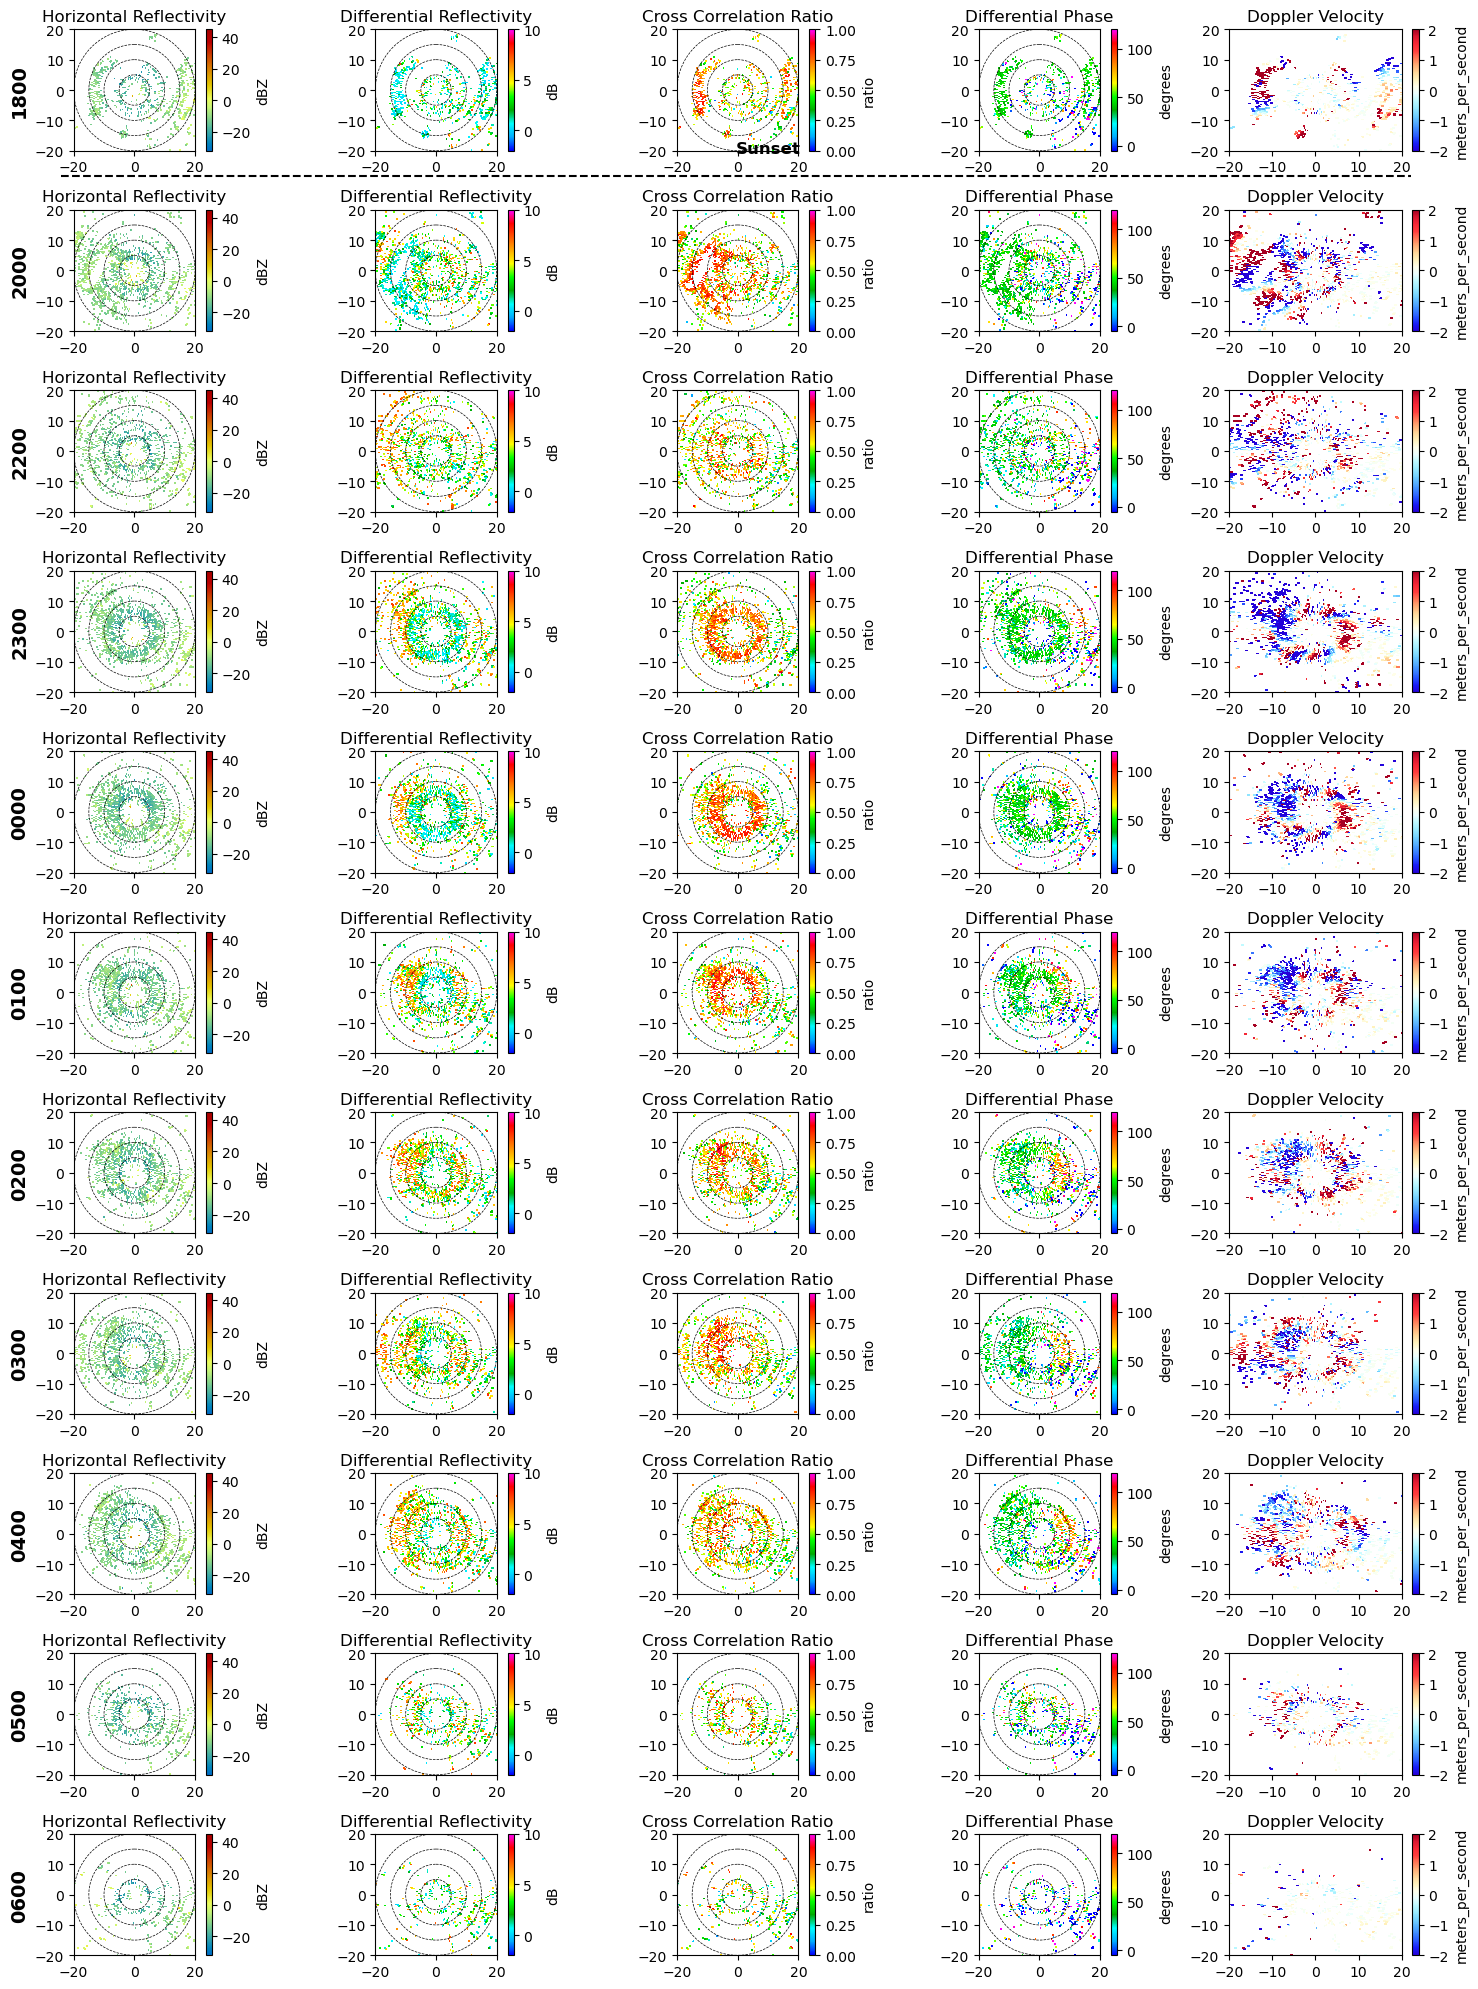

In [114]:
if True:
    ns.plot_ppis(20,0,'lp', plot_velocity = True)

/tmp/ipykernel_574/3383349561.py:248: RuntimeWarning: Mean of empty slice
  means_array = np.nanmean(masked_values, axis=0)


<Figure size 800x500 with 0 Axes>

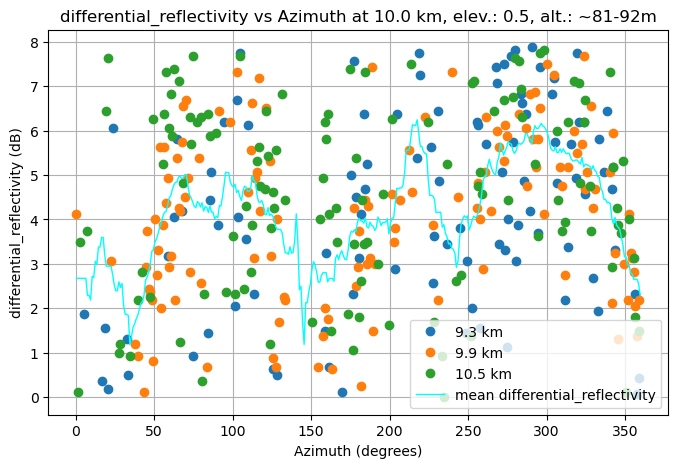

In [117]:
#(self, R: int, gates: list[int], ele_index:int, pulse: str, time: str, field_name: str, filtered: bool, smoothing_window: int = 20,save_fig: str = None)
if True:
    ns.plot_range_single_field_cartesian(
        R = 10000,
        gates = [-1,0,1],
        ele_index = 0,
        pulse = 'lp',
        time = '0400',
        field_name= 'differential_reflectivity',
        filtered = True,
        smoothing_window=20
    )

/tmp/ipykernel_574/3383349561.py:248: RuntimeWarning: Mean of empty slice
  means_array = np.nanmean(masked_values, axis=0)


<Figure size 800x500 with 0 Axes>

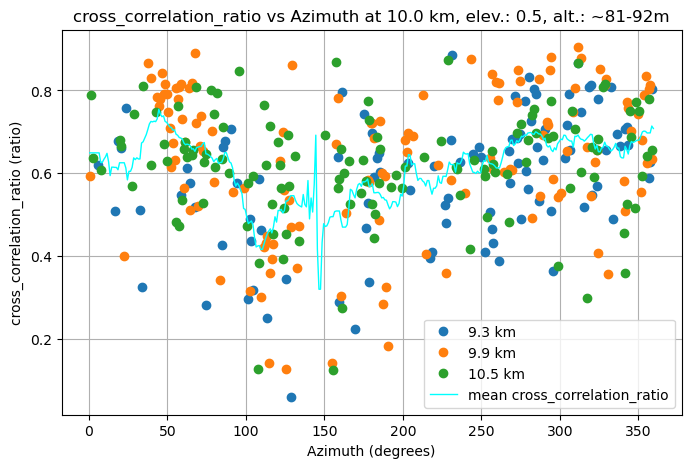

In [119]:
if True:
    ns.plot_range_single_field_cartesian(
        R = 10000,
        gates = [-1,0,1],
        ele_index = 0,
        pulse = 'lp',
        time = '0400',
        field_name = 'cross_correlation_ratio',
        filtered = True
    )

/tmp/ipykernel_573/1253685459.py:242: RuntimeWarning: Mean of empty slice
  means_array = np.nanmean(values_array, axis=0)


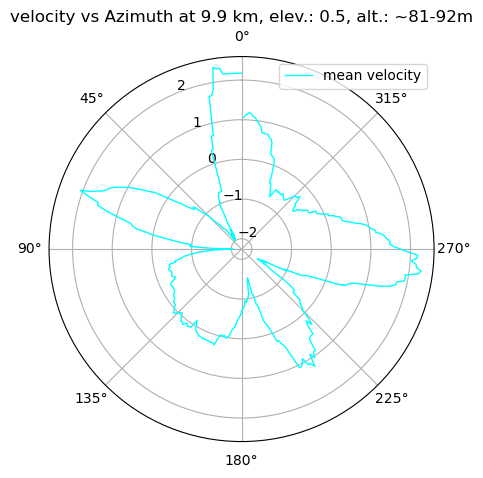

In [60]:
if True:
    ns.plot_range(
        R = 10000,
        gates = [-1,0,1],
        ele_index = 0,
        pulse = 'lp',
        time = '0400',
        field_name = 'velocity',
        filtered = True
    )

In [200]:
radar = night_objects['07'].processed_radar_dict['lp']['0400']

start_ray = radar.sweep_start_ray_index['data'][0]
end_ray = radar.sweep_end_ray_index['data'][0] + 1
phidp = radar.fields['differential_phase']['data'][start_ray:end_ray, :].reshape(360*425)
Z = radar.fields['reflectivity']['data'][start_ray:end_ray, :].reshape(360*425)
Zdr = radar.fields['differential_reflectivity']['data'][start_ray:end_ray, :].reshape(360*425)
rho_hv = radar.fields['cross_correlation_ratio']['data'][start_ray:end_ray, :].reshape(360*425)
velocity = radar.fields['velocity']['data'][start_ray:end_ray, :].reshape(360*425)

Z_bins = np.arange(-10, 60, 5)
Zdr_bins = np.arange(-2, 14, 2)
rho_hv_bins = np.arange(0,1.1,0.1)
velocity_bins = np.arange(-3,4,1)

[-10, -5, 0, 5, 10, 15, 20, 25] [38.029236, 14.211115, -0.1834239, 49.59961, -23.115234, 57.45117, 13.029785, -73.65234]


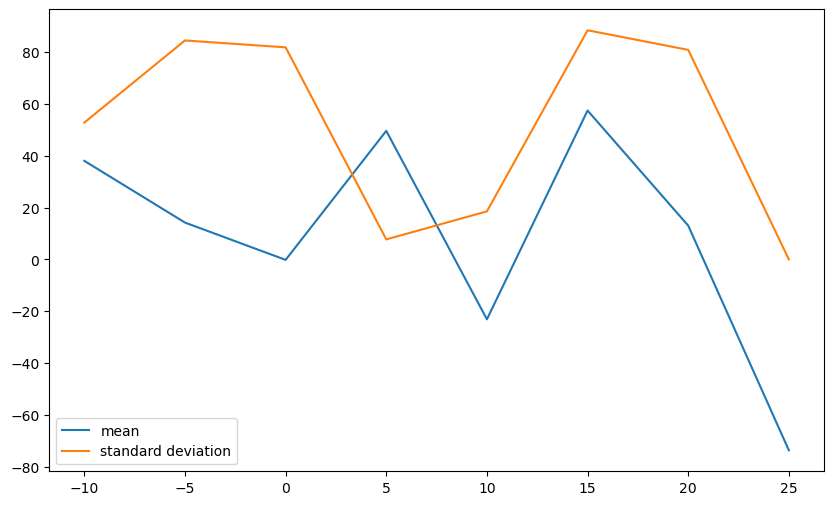

In [206]:
_ = bin_arrays(Z, phidp, Z_bins, plot = True)

## Generating ten nights worth of objects and plots

In [12]:
# Make files dict for week to have night object dict 

days = ['07', '08' , '09', '10', '11', '12', '13', '14', '15','16','17']

files_dict = {
    day :
        {
            'evening' : base_path + f'chenies/2020/202009{days[counter]}_polar_pl_radar05_aggregate.h5',
            'night' : base_path + f'chenies/2020/202009{days[counter+1]}_polar_pl_radar05_aggregate.h5'
        } for counter, day in enumerate(days[:-1])
    } 


night_objects = {
    day : NightSweeper(files_dict[day], times, pulses) for day in days[:-1]
}

['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200
lp 0300
lp 0400
['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200
lp 0300
lp 0400
['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200
lp 0300
lp 0400
['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200
lp 0300
lp 0400
['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200
lp 0300
lp 0400
['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200
lp 0300
lp 0400
['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200
lp 0300
lp 0400
['lp']
Loading evening files...
lp 1800
lp 2000
lp 2200
lp 2300
Loading night files...
lp 0000
lp 0100
lp 0200


In [13]:
if False:
    eles = [0,1]
    filtered_list = [('filtered', True), ('unfiltered', False)]
    
    for day in days[:-1]:
        for ele in eles:
            for filtered_desc, filtered_bool in filtered_list:
                night_objects[day].plot_ppis(20,ele,'lp', save_fig = f'week_07092020_sweep/ele{ele}/night_of_{day}_ele{ele}_R20_{filtered_desc}.png', filtered=filtered_bool)

# Individual night case studies

## 14th - good for insects

Massive insect explosion, little cloud cover. Can see a clearly distinct distribution in the differential phase to the cloudy night below. Lots of noise, not representative of a clear alignment.

### Full PPI

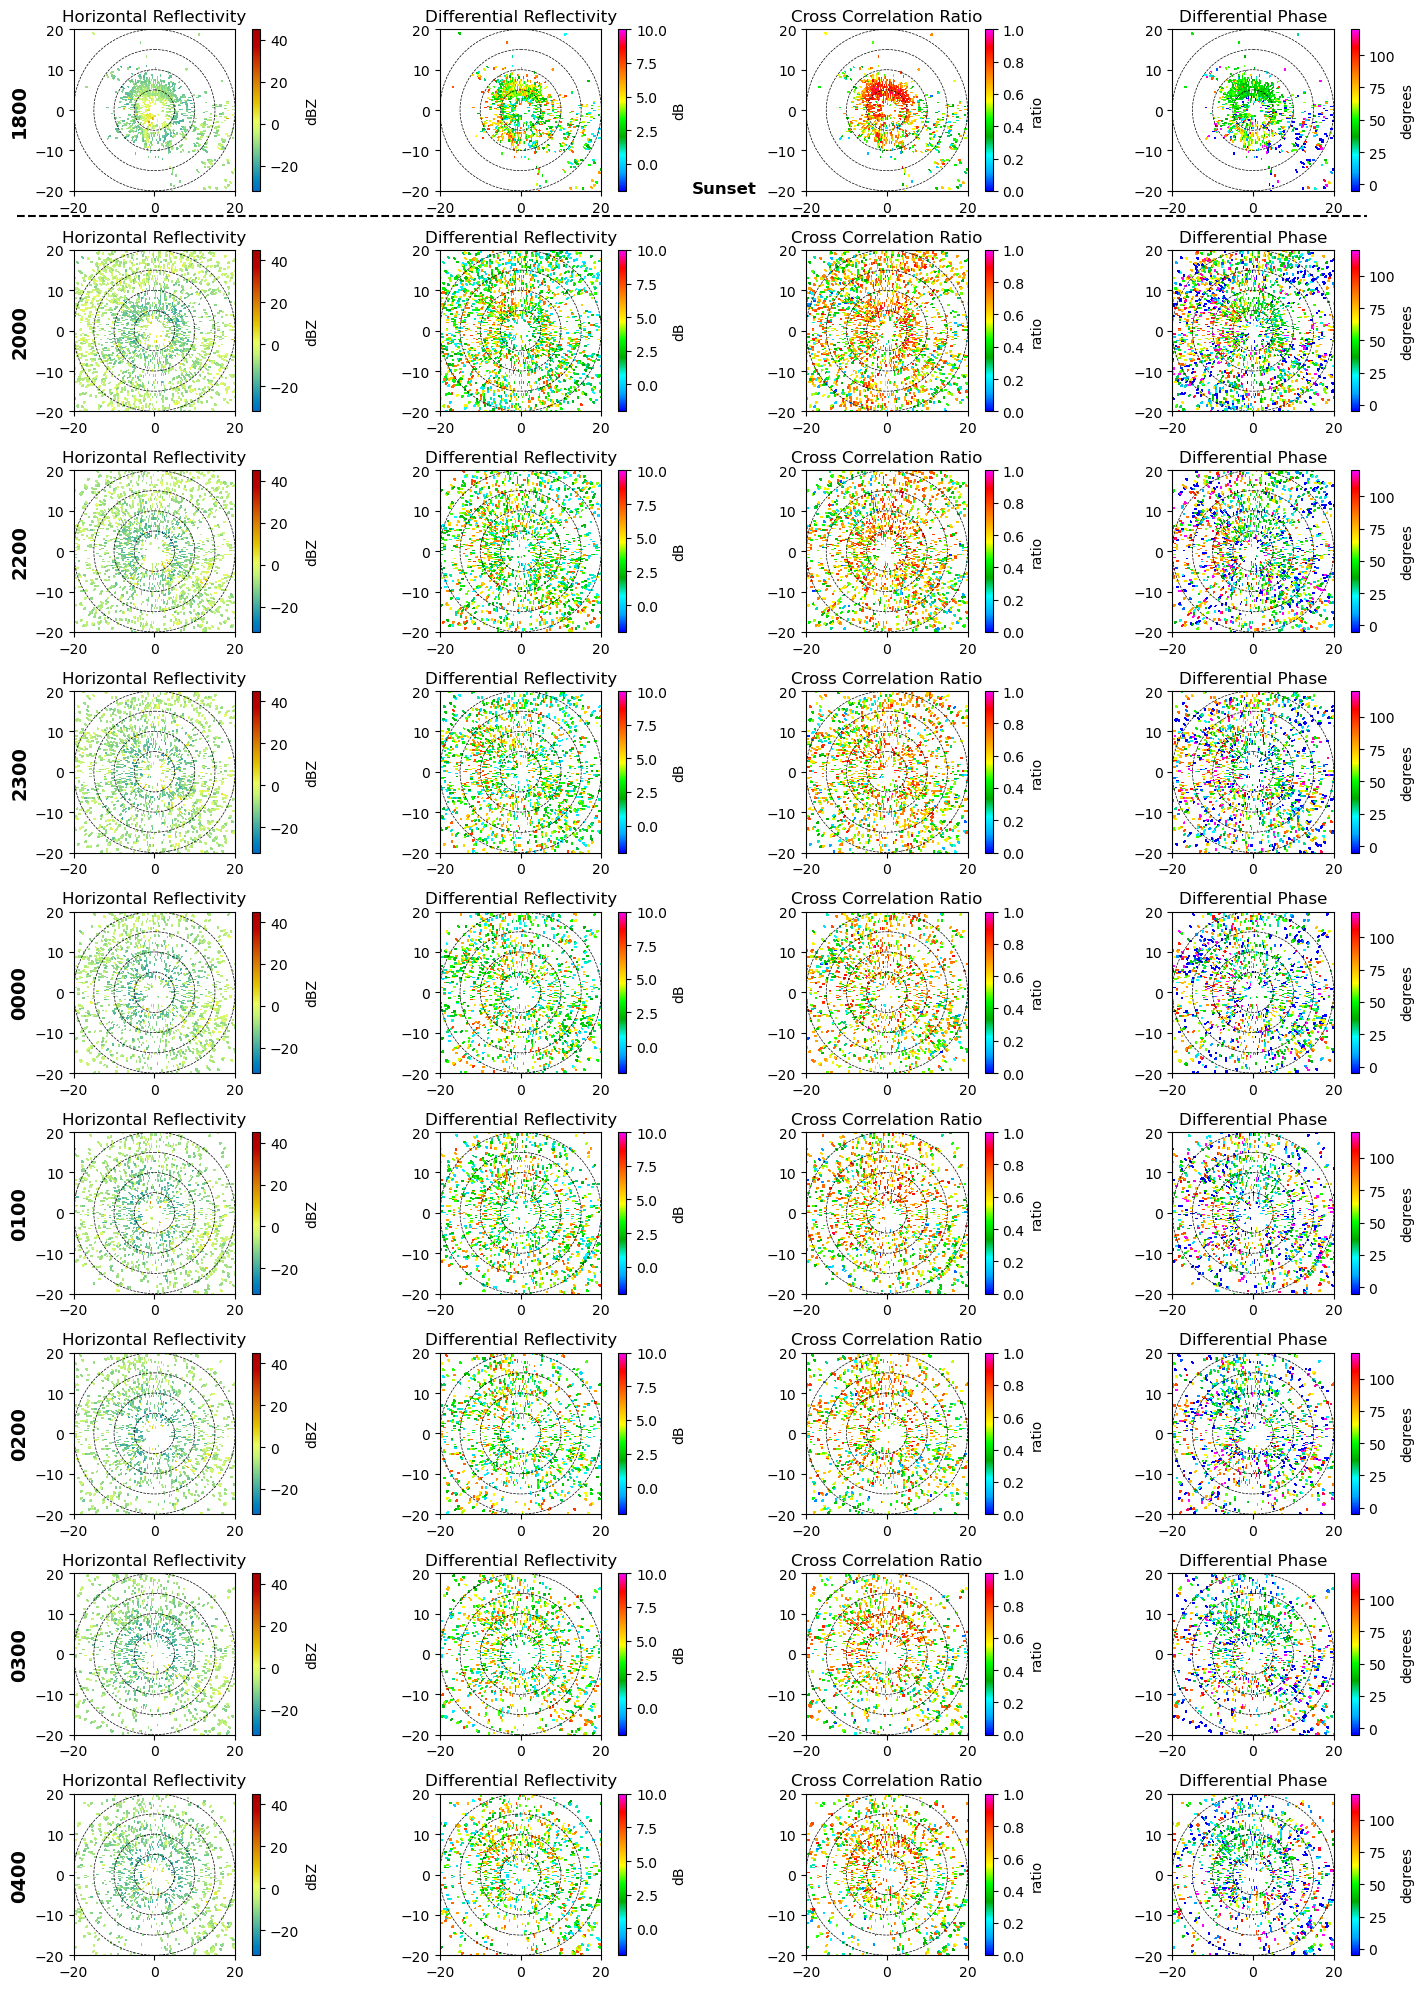

In [14]:
night_objects['14'].plot_ppis(20,0, 'lp')

### Radius plot

/tmp/ipykernel_872/813497217.py:242: RuntimeWarning: Mean of empty slice
  means_array = np.nanmean(values_array, axis=0)


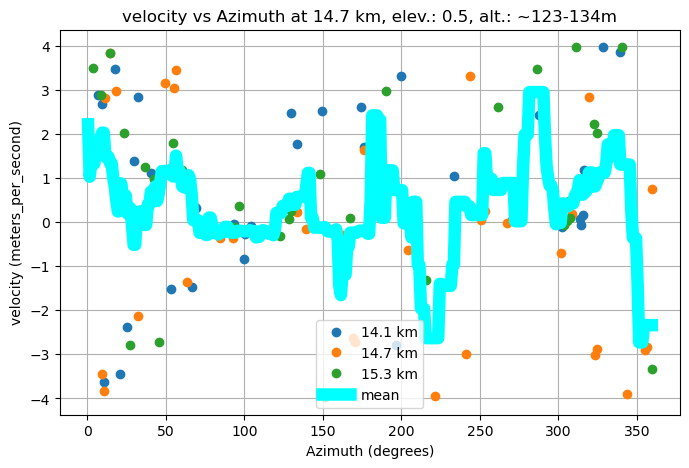

In [15]:
night_objects['14'].plot_range(
    R = 15000,
    gates = [-1,0,1],
    ele_index = 0,
    pulse = 'lp',
    time = '0400',
    field_name = 'velocity',
    filtered = True,
    smoothing_window = 20,
)

In [16]:
360*425

153000

## This loses position within the radar, I will need to do a version of this that keeps position within the radar

For recursive binning, I'll need to keep the bin index and bin both data before

Fire range subset into binning algorithm

In [213]:
def bin_arrays(binning_array, array_to_bin, bins, plot: bool = False):

    bin_index = np.digitize(binning_array, bins)
    present_lower_bin_labels = []
    
    results = {}

    for i in range(1, len(bins)):
        mask = bin_index == i
        values = array_to_bin[mask]
        values = values[~np.isnan(values)]  # drop NaNs
        
        
        if len(values) > 0:
            present_lower_bin_labels.append(bins[i-1])
            results[bins[i-1]] = {
                "mean": np.mean(values),
                "median": np.median(values),
                "std": np.std(values),
                "n": len(values),
                "values": values  # keep raw for histogram/plot
            }
    
    if plot:
        
        plt.figure(figsize=(10,6))
    
        for refl_bin, stats in results.items():
                plt.hist(stats["values"], bins=30, alpha=0.5, label=f"{refl_bin}–{refl_bin+(bins[1]-bins[0])} dBZ")
        
        #plt.xlabel("Differential Phase (degrees)")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
    
        plt.figure(figsize=(10,6))
        means = []
        stds = []
        for refl_bin, stats in results.items():
            means.append(stats['mean'])
            stds.append(stats['std'])
            
        plt.plot(present_lower_bin_labels, means, label = 'mean')
        plt.plot(present_lower_bin_labels, stds, label = 'standard deviation')
        
        plt.xlabel("Binning variable (placeholder)")
        plt.ylabel("Target variable")
        plt.legend()
        plt.show()

    
    
    return bin_index, results

In [214]:
radar = night_objects['14'].processed_radar_dict['lp']['0400']

start_ray = radar.sweep_start_ray_index['data'][0]
end_ray = radar.sweep_end_ray_index['data'][0] + 1
phidp = radar.fields['differential_phase']['data'][start_ray:end_ray, :].reshape(360*425)
Z = radar.fields['reflectivity']['data'][start_ray:end_ray, :].reshape(360*425)
Zdr = radar.fields['differential_reflectivity']['data'][start_ray:end_ray, :].reshape(360*425)
rho_hv = radar.fields['cross_correlation_ratio']['data'][start_ray:end_ray, :].reshape(360*425)
velocity = radar.fields['velocity']['data'][start_ray:end_ray, :].reshape(360*425)

In [215]:
Z.shape, Zdr.shape

((153000,), (153000,))

In [216]:
Z_bins = np.arange(-10, 60, 5)
Zdr_bins = np.arange(-2, 14, 2)
rho_hv_bins = np.arange(0,1.1,0.1)
velocity_bins = np.arange(-3,4,1)

In [217]:
rho_hv_bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

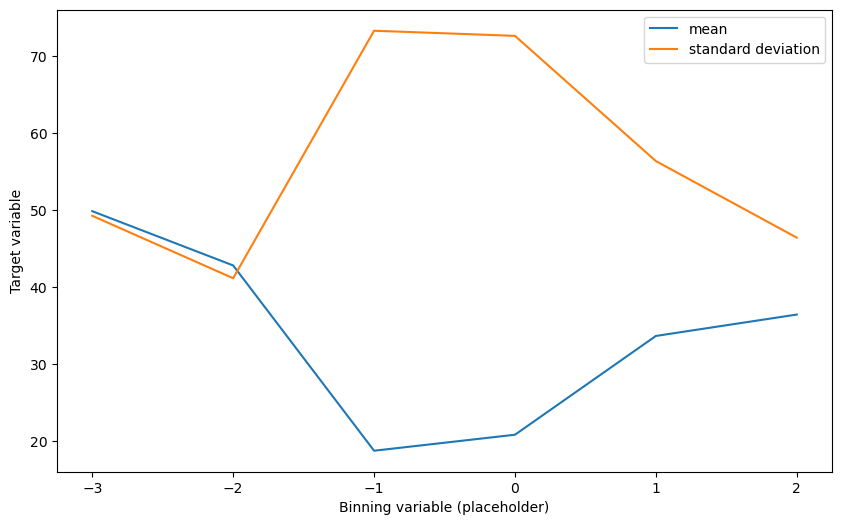

In [220]:
_ = bin_arrays(velocity, phidp, velocity_bins, plot = True)

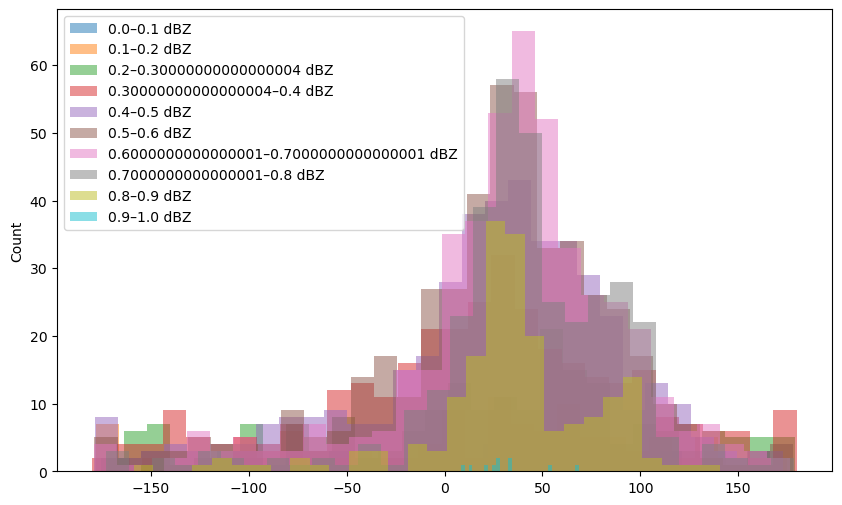

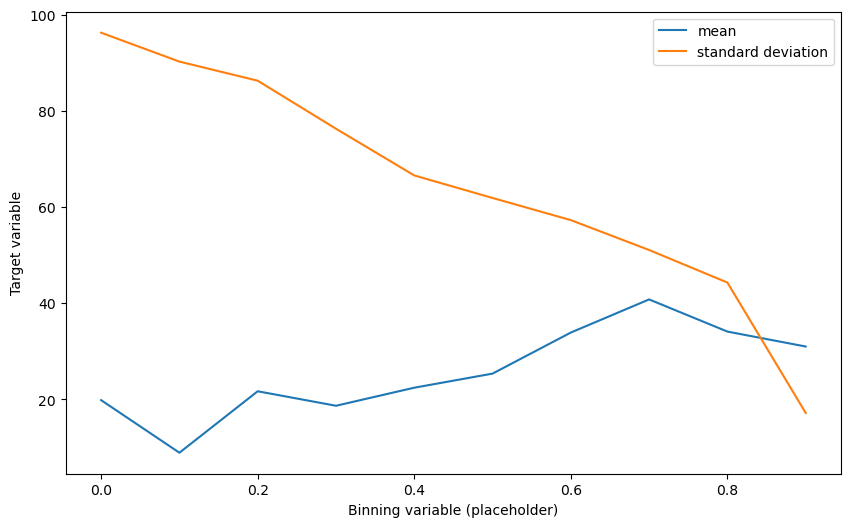

In [219]:
_ = bin_arrays(rho_hv, phidp, rho_hv_bins, plot = True)

call bin arrays inside an output dictionary loop - output to subplot

In [22]:
results = {}

for i in range(1, len(bins)):
    mask = bin_index == i
    values = phidp[mask]
    print(len(values), len(phidp))
    values = values[~np.isnan(values)]  # drop NaNs

    if len(values) > 0:
        results[bins[i-1]] = {
            "mean": np.mean(values),
            "median": np.median(values),
            "std": np.std(values),
            "n": len(values),
            "values": values  # keep raw for histogram/plot
        }

697 153000
489 153000
299 153000
151 153000
41 153000
6 153000
1 153000
0 153000
0 153000
0 153000
0 153000
0 153000
0 153000


In [24]:
bins

array([-10,  -5,   0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,
        55])

Make functions to do binning - bin other variables and specific ranges

## 7th - Cloudy night for comparison


Clear ring of cloud, distinct to insects, but possiblystill seeing high altitude insects? Targetting clear ring of cloud shows minimal differential phase, and also suggests a differential phase on transmission for the radar.

### Full PPI

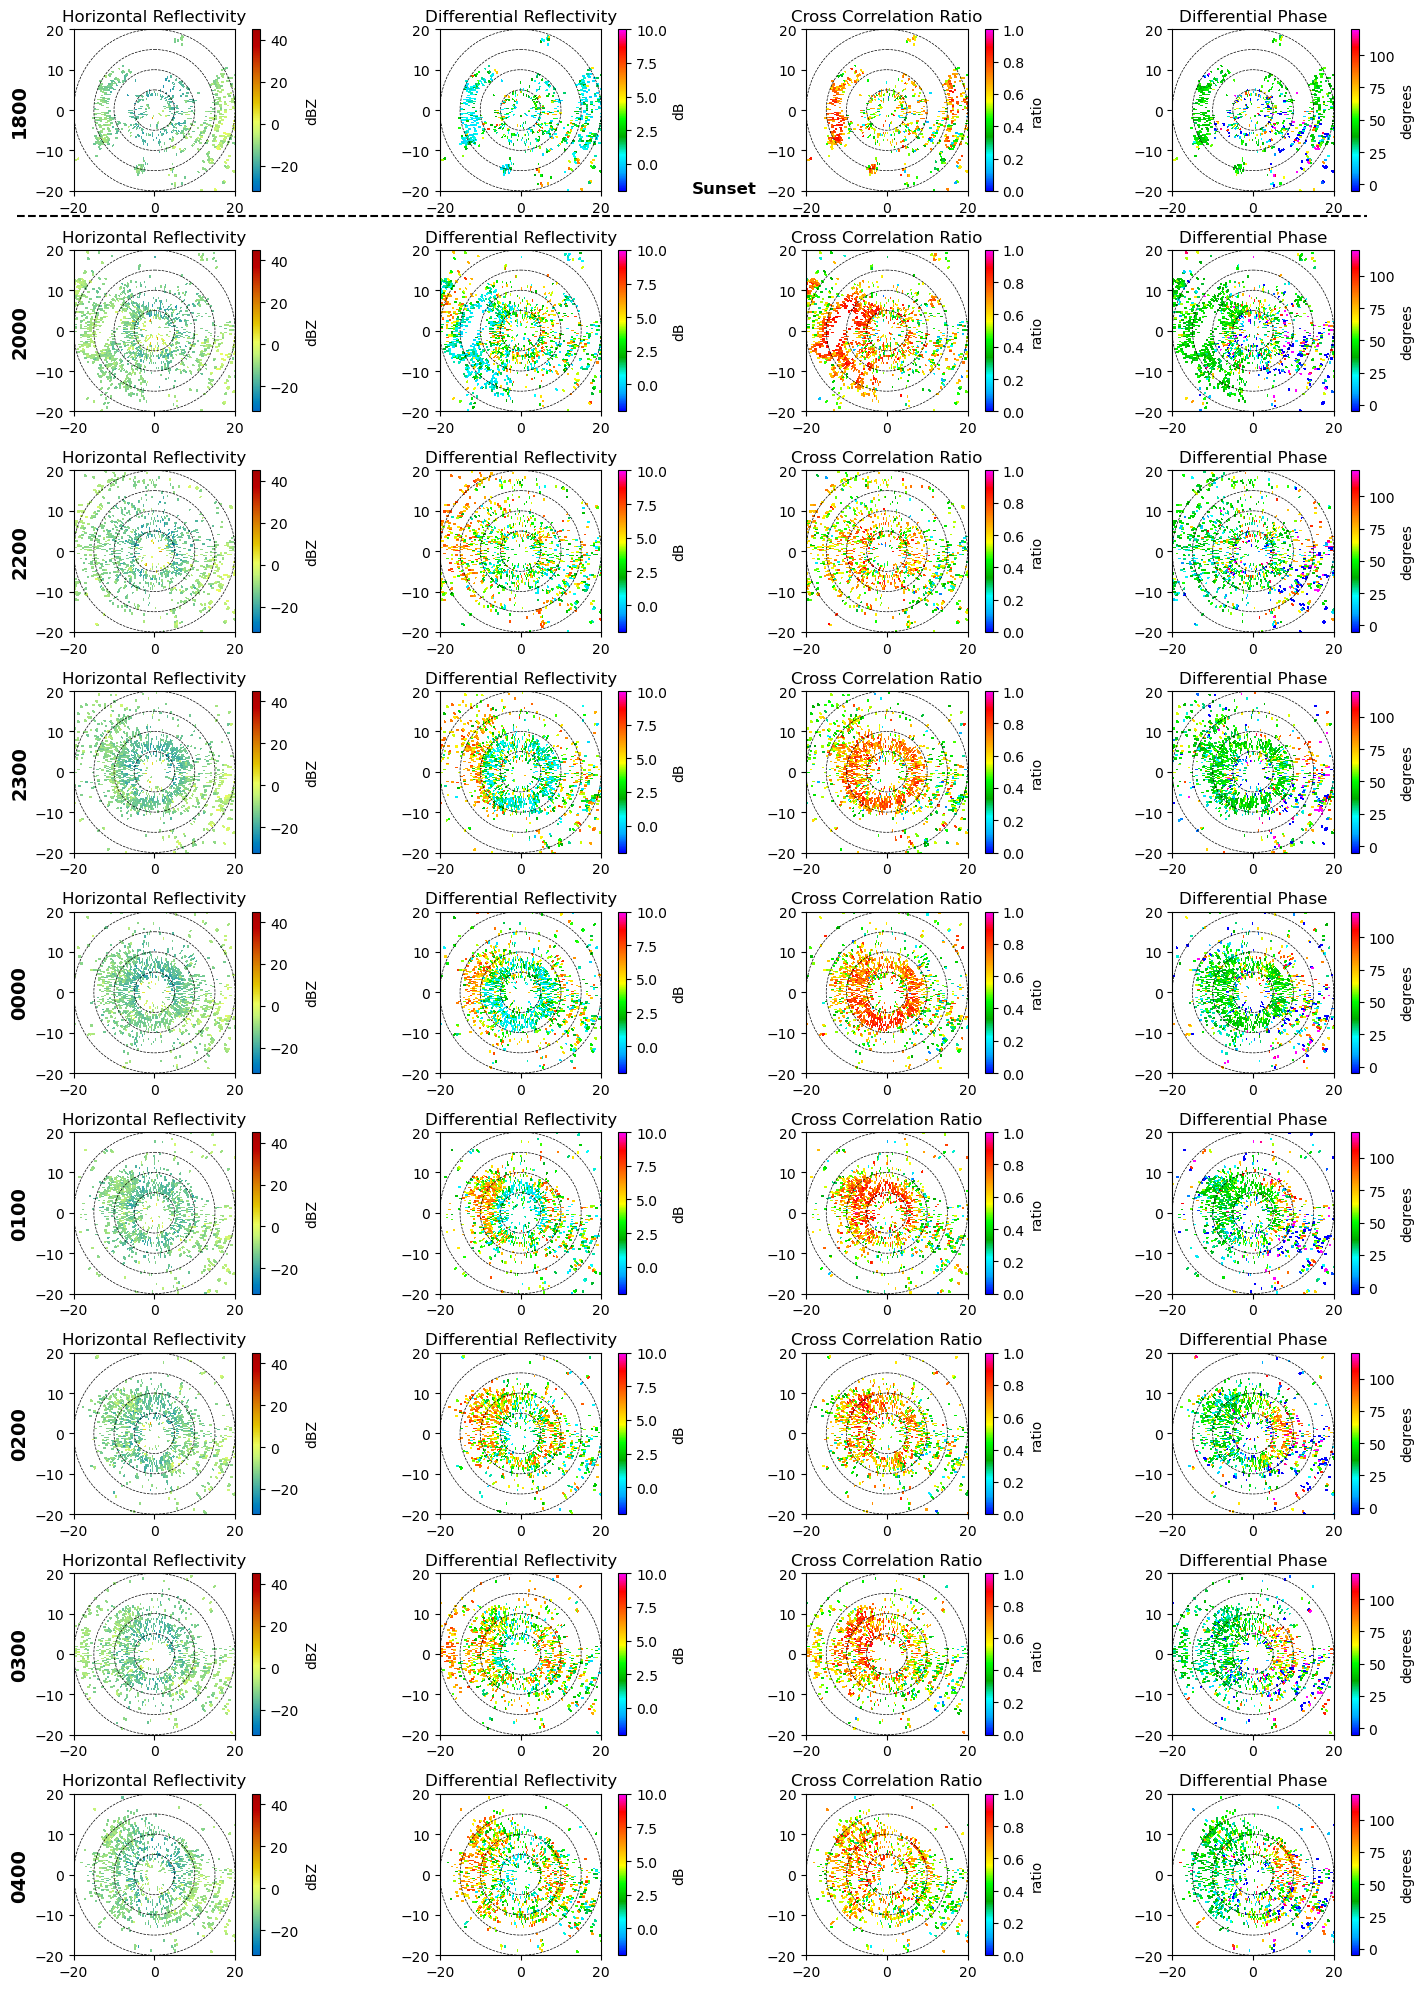

In [26]:
night_objects['07'].plot_ppis(20,0, 'lp')

### Radius plot

/tmp/ipykernel_872/813497217.py:242: RuntimeWarning: Mean of empty slice
  means_array = np.nanmean(values_array, axis=0)


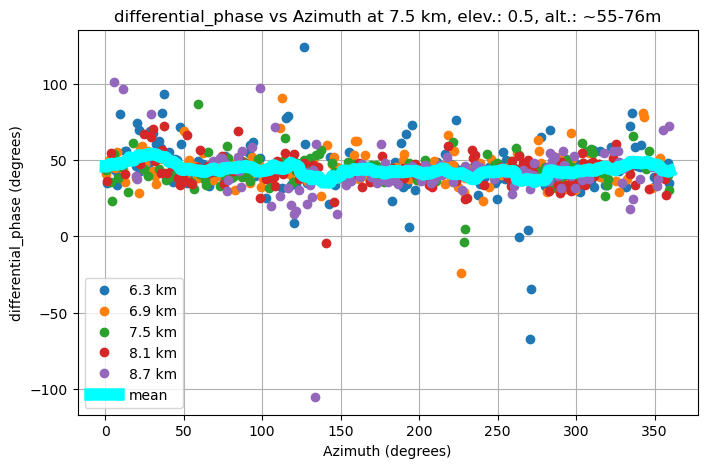

In [27]:
night_objects['07'].plot_range(
    R = 7500,
    gates = [-2, -1,0,1, 2],
    ele_index = 0,
    pulse = 'lp',
    time = '0000',
    field_name = 'differential_phase',
    filtered = True,
    smoothing_window = 20,
)

## Next